In [3]:
!pip install fvcore

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import os, sys
import timm
import torch.nn.functional as F
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from collections import OrderedDict
from torch_optimizer import Ranger
torch.multiprocessing.set_sharing_strategy('file_descriptor')

/home/anton/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-28 08:13:18.010615: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 08:13:18.035819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 08:13:18.035841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 08:13:18.036523: E external/local_xla/xla/stream_exec

In [2]:
rd = 'rsna-2024-lumbar-spine-degenerative-classification'
OUTPUT_DIR = 'rsna-results-3d'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = [256, 256]
N_FOLDS = 5
EPOCHS = 50
USE_AMP = True
N_LABELS = 25
N_CLASSES = 3 * N_LABELS
AUG_PROB = 0.75
SELECTED_FOLDS = [0, 1, 2, 3, 4]
SEED = 69
GRAD_ACC = 2
TGT_BATCH_SIZE = 8
IN_CHANS = 24
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 10
LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True
MODEL_NAME = 'convnext_pico.d1_in1k'
# MODEL_NAME = 'convnextv2_pico.fcmae'
NOT_DEBUG = True
N_WORKERS = 4

In [3]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

In [5]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [6]:
df = df.fillna(-100)

In [7]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_20435/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]
model_names = list(df.columns)[1:]
model_names

['spinal_canal_stenosis_l1_l2',
 'spinal_canal_stenosis_l2_l3',
 'spinal_canal_stenosis_l3_l4',
 'spinal_canal_stenosis_l4_l5',
 'spinal_canal_stenosis_l5_s1',
 'left_neural_foraminal_narrowing_l1_l2',
 'left_neural_foraminal_narrowing_l2_l3',
 'left_neural_foraminal_narrowing_l3_l4',
 'left_neural_foraminal_narrowing_l4_l5',
 'left_neural_foraminal_narrowing_l5_s1',
 'right_neural_foraminal_narrowing_l1_l2',
 'right_neural_foraminal_narrowing_l2_l3',
 'right_neural_foraminal_narrowing_l3_l4',
 'right_neural_foraminal_narrowing_l4_l5',
 'right_neural_foraminal_narrowing_l5_s1',
 'left_subarticular_stenosis_l1_l2',
 'left_subarticular_stenosis_l2_l3',
 'left_subarticular_stenosis_l3_l4',
 'left_subarticular_stenosis_l4_l5',
 'left_subarticular_stenosis_l5_s1',
 'right_subarticular_stenosis_l1_l2',
 'right_subarticular_stenosis_l2_l3',
 'right_subarticular_stenosis_l3_l4',
 'right_subarticular_stenosis_l4_l5',
 'right_subarticular_stenosis_l5_s1']

In [9]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS, 3), dtype=np.float32)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        
        sat1 = glob(f'./cvt_png/{st_id}/Sagittal T1/*.png')
        sat1 = sorted(sat1)
    
        step = len(sat1) / (IN_CHANS-1)
        st = 0
        end = len(sat1)+0.0001
        
        if len(sat1) != 0:
        
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = sat1[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i, 0] = img.astype(np.float32)
                except:
                    #print(f'failed to load on {st_id}, Sagittal T1')
                    pass
            
        # Sagittal T2/STIR
        sat2 = glob(f'./cvt_png/{st_id}/Sagittal T2_STIR/*.png')
        sat2 = sorted(sat2)
    
        step = len(sat2) / (IN_CHANS-1)
        st = 0
        end = len(sat2)+0.0001
        
        if len(sat2) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = sat2[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i, 1] = img.astype(np.float32)
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass
            
        # Axial T2
        axt2 = glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / (IN_CHANS-1)
        st = 0
        end = len(axt2)+0.0001
                
        if len(axt2) != 0:
            for i, j in enumerate(np.arange(st, end, step)):
                try:
                    p = axt2[max(0, int((j-0.5001).round()))]
                    img = Image.open(p).convert('L')
                    img = np.array(img)
                    x[..., i, 2] = img.astype(np.float32)
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass  
            
        assert np.sum(x)>0
        if self.transform is not None:
            for i in range(3):
                x[..., i] = self.transform(image=x[..., i])['image']

        x = x.transpose(3, 2, 0, 1)
        
                
        return x, label

In [10]:
transforms_train = A.Compose([
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=2, min_width=2, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not AUG:
    transforms_train = transforms_val

x stat: torch.Size([1, 3, 24, 256, 256]) tensor(-1.) tensor(0.9298) tensor(-0.7459) tensor(0.3706)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


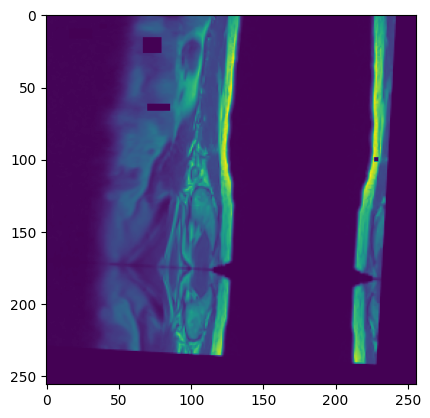

y stat: (256, 256) -1.0 0.8676829 -0.7904649 0.34121686

x stat: torch.Size([1, 3, 24, 256, 256]) tensor(-1.) tensor(0.9385) tensor(-0.7417) tensor(0.2923)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


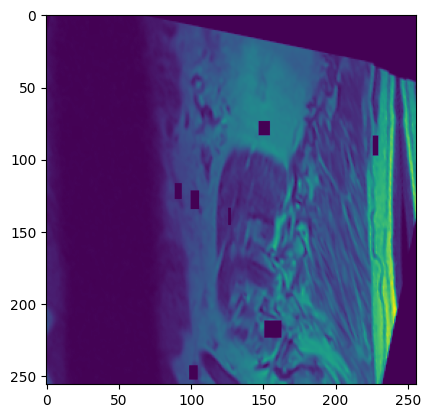

y stat: (256, 256) -1.0 0.7795748 -0.691396 0.31816265



In [11]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=False,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==2:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy()[0,0,1,...]
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [12]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=1, n_classes=150, pretrained=True, features_only=False,
                embed_size=512, output_size=512, num_classes=10):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
        self.rnn = nn.LSTM(embed_size, output_size, num_layers=1, 
                           bidirectional=True, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(2*output_size, num_classes)
        self.n_classes = n_classes
    
    def forward(self, x):
        batch_size = x.shape[0]
        num_images = x.shape[1]

        x = x.reshape(x.shape[0]*x.shape[1], 1, x.shape[2], x.shape[3])
        
            
        embeddings = self.model(x)
        embeddings = embeddings.view(batch_size, num_images, -1)
    
        
        outs, (hc, cc) = self.rnn(embeddings)
        result = self.linear(self.relu(outs[:, -1, :]))
        return result
    
def get_last_layer(model, x):
    y = model.forward_features(x)
    print(y.shape)

In [13]:
torch.hub.list('facebookresearch/pytorchvideo')

Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


['c2d_r50',
 'csn_r101',
 'efficient_x3d_s',
 'efficient_x3d_xs',
 'i3d_r50',
 'mvit_base_16',
 'mvit_base_16x4',
 'mvit_base_32x3',
 'r2plus1d_r50',
 'slow_r50',
 'slow_r50_detection',
 'slowfast_16x8_r101_50_50',
 'slowfast_r101',
 'slowfast_r50',
 'slowfast_r50_detection',
 'x3d_l',
 'x3d_m',
 'x3d_s',
 'x3d_xs']

In [14]:
class Model3d(nn.Module):
    def __init__(self, model , input_channels = 3):
        super(Model3d, self).__init__()
        self.model = model
        self.bn = nn.BatchNorm3d(1)
        self.cnn3d = nn.Conv3d( input_channels , 1 , 3)
        self.pool = nn.AdaptiveAvgPool3d((20, 192, 192))
        self.bn2 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.cnn2d = nn.Conv2d(20 , 3 , 3 , stride = 1 , padding = 1)
    
    def forward(self , x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2], x.shape[3])
        x = self.bn(x)
        x = self.cnn3d(x)
        x = x.squeeze(1)
        x = self.relu(x)
        x = self.pool(x) #changing Depth , width , height to 144
        x = self.cnn2d(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.model(x)
        
        return x
        



In [15]:
class TimmModel3d(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel3d, self).__init__()

        self.encoder = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_xs', pretrained=True)
        self.linear = nn.Linear(400, 75)
    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        out = self.encoder(x)
        out = F.relu(out)
        out = self.linear(out)
        return out

In [16]:
m = TimmModel3d(MODEL_NAME)
m = m.to(DEVICE)
i = torch.randn(2, 3, IN_CHANS, 224, 224).to(DEVICE)
with torch.no_grad():
    out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


torch.Size([75]) tensor(-0.7728, device='cuda:0') tensor(0.5695, device='cuda:0')
torch.Size([75]) tensor(-0.5156, device='cuda:0') tensor(0.5661, device='cuda:0')


In [17]:
del m, i, out

In [18]:
%time
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=2048)

val_losses = []
train_losses = []
df_tr, df_test = train_test_split(df, test_size=2/7, random_state=SEED)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
device = DEVICE
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    loss_scale = 1
    if NOT_DEBUG == False:
        if fold == 1: break;
    if fold not in SELECTED_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        print(len(trn_idx), len(val_idx))
        df_train = df.iloc[trn_idx]
        df_valid = df.iloc[val_idx]

        train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
        train_dl = DataLoader(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    pin_memory=False,
                    drop_last=True,
                    num_workers=N_WORKERS
                    )

        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=BATCH_SIZE*2,
                    shuffle=False,
                    pin_memory=False,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )

#         model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
        model = TimmModel3d(MODEL_NAME)
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
#         if os.path.exists(fname):
#             model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
#             model.load_state_dict(torch.load(fname))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LR*2, weight_decay=WD)
#         optimizer = torch.optim.SGD(model.parameters(), lr=LR*2, weight_decay=WD, nesterov=True, momentum=0.9)

        warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
        num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
        num_cycles = 0.475
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=warmup_steps,
                                                    num_training_steps=num_total_steps,
                                                    num_cycles=num_cycles)
#         scheduler = get_linear_schedule_with_warmup(optimizer,
#                                                     num_warmup_steps=warmup_steps,
#                                                     num_training_steps=num_total_steps)

        weights = torch.tensor([1.0, 2.0, 4.0])
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        criterion_cpu = nn.CrossEntropyLoss(weight=weights)
        best_loss = 1.2
        es_step = 0

        for epoch in range(1, EPOCHS+1):
            print(f'start epoch {epoch}')
            model.train()
            total_loss = 0
            with tqdm(train_dl, leave=True) as pbar:
                optimizer.zero_grad()
                for idx, (x, t) in enumerate(pbar):  
                    op = ['nothing', 'nothing', 'nothing', 'nothing', 'nothing']
                    x = x.to(device)
                    t = t.to(device)
#                     t = torch.tensor(np.array(one_h(list(t.detach().cpu().numpy())))).to(device)
                    rc = random.sample(op, 1)
                    if rc[0] == 'mixup':
                        x = x.detach().cpu().numpy()
                        t = t.detach().cpu().numpy()
                        reference_data = [{'image':x[i], 'proba': t[i]} 
                                        for i in range(len(x))]
                        tr = A.Compose([A.MixUp(reference_data=reference_data,
                                              read_fn=read_fn, p=0.5)])
                        for i in range(len(x)):
                            transformed = tr(image=x[i], global_label=t[i])
                            x[i] = transformed['image']
                            t[i] = transformed['global_label']
                        
                        x = torch.tensor(x).to(device)
                        t = torch.tensor(t).to(device)
                        
                    with autocast:
                        loss = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
                            loss = loss + loss_scale * criterion(pred, gt) / N_LABELS
                        
                        if not math.isfinite(loss):
                            loss = torch.tensor(1.2 * loss_scale * GRAD_ACC, requires_grad=True)
                        total_loss += loss.item()
                        if GRAD_ACC > 1:
                            loss = loss / GRAD_ACC

                    
                    

                    pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss.item()*GRAD_ACC:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
#                     scaler.scale(loss).backward()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                    if (idx + 1) % GRAD_ACC == 0:
#                         scaler.step(optimizer)
#                         scaler.update()
                        optimizer.step()
                        optimizer.zero_grad()
                        if scheduler is not None:
                            scheduler.step()                    

            train_loss = total_loss/len(train_dl)
            print(f'train_loss:{train_loss/loss_scale:.6f}')
            train_losses.append(train_loss)
            total_loss = 0

            model.eval()
            y_preds, labels = [], []
            with tqdm(valid_dl, leave=True) as pbar:
                with torch.no_grad():
                    for idx, (x, t) in enumerate(pbar):

                        x = x.to(device)
                        t = t.to(device)

                        with autocast:
                            loss = 0
                            loss_ema = 0
                            y = model(x)
                            for col in range(N_LABELS):
                                pred = y[:,col*3:col*3+3]
                                gt = t[:,col]

                                loss = loss + criterion(pred, gt) / N_LABELS
                                y_pred = pred.float()
                                y_preds.append(y_pred.cpu())
                                labels.append(gt.cpu())
                                
                            if not math.isfinite(loss):
                                loss = torch.tensor(1.2 * loss_scale * GRAD_ACC, requires_grad=True)
                            
                            total_loss += loss.item()   

            val_loss = total_loss/len(valid_dl)
            y_preds = torch.cat(y_preds, dim=0)
            print(y_preds.shape)
            labels = torch.cat(labels)

            val_weighted_loss = criterion_cpu(y_preds, labels)
            print(f'val_loss:{val_loss:.6f}')
            val_losses.append(val_loss)
            if val_weighted_loss < best_loss:

                if device!='cuda:0':
                    model.to('cuda:0')                

                print(f'epoch:{epoch}, best weighted_logloss updated from {best_loss:.6f} to {val_weighted_loss:.6f}')
                best_loss = val_weighted_loss
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
                print(f'{fname} is saved')
                es_step = 0

                if device!='cuda:0':
                    model.to(device)

            else:
                es_step += 1
                if es_step >= EARLY_STOPPING_EPOCH:
                    print('early stopping')
                    break  
                                

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs
##############################
Start fold 0
##############################
1580 395


Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


start epoch 1


100%|████████████| 395/395 [01:44<00:00,  3.77it/s, loss=0.907505, lr=1.996e-05]


train_loss:1.024447


100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.81it/s]


torch.Size([9875, 3])
val_loss:0.851071
epoch:1, best weighted_logloss updated from 1.200000 to 0.929161
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 2


100%|████████████| 395/395 [01:43<00:00,  3.81it/s, loss=0.531993, lr=3.992e-05]


train_loss:0.750629


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.05it/s]


torch.Size([9875, 3])
val_loss:0.767504
epoch:2, best weighted_logloss updated from 0.929161 to 0.852853
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 3


100%|████████████| 395/395 [01:43<00:00,  3.80it/s, loss=0.566180, lr=5.988e-05]


train_loss:0.713745


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.03it/s]


torch.Size([9875, 3])
val_loss:0.752060
epoch:3, best weighted_logloss updated from 0.852853 to 0.844437
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 4


100%|████████████| 395/395 [01:43<00:00,  3.80it/s, loss=0.522277, lr=7.984e-05]


train_loss:0.690406


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.03it/s]


torch.Size([9875, 3])
val_loss:0.738261
epoch:4, best weighted_logloss updated from 0.844437 to 0.830394
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 5


100%|████████████| 395/395 [01:43<00:00,  3.80it/s, loss=1.219191, lr=9.980e-05]


train_loss:0.679178


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.02it/s]


torch.Size([9875, 3])
val_loss:0.710179
epoch:5, best weighted_logloss updated from 0.830394 to 0.797660
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 6


100%|████████████| 395/395 [01:43<00:00,  3.81it/s, loss=0.752570, lr=9.989e-05]


train_loss:0.663081


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.05it/s]


torch.Size([9875, 3])
val_loss:0.687648
epoch:6, best weighted_logloss updated from 0.797660 to 0.769682
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 7


100%|████████████| 395/395 [01:43<00:00,  3.81it/s, loss=0.550453, lr=9.957e-05]


train_loss:0.651144


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.01it/s]


torch.Size([9875, 3])
val_loss:0.672992
epoch:7, best weighted_logloss updated from 0.769682 to 0.745539
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 8


100%|████████████| 395/395 [01:43<00:00,  3.81it/s, loss=0.402665, lr=9.903e-05]


train_loss:0.643440


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.07it/s]


torch.Size([9875, 3])
val_loss:0.663058
epoch:8, best weighted_logloss updated from 0.745539 to 0.728446
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 9


100%|████████████| 395/395 [01:43<00:00,  3.80it/s, loss=0.616946, lr=9.827e-05]


train_loss:0.630040


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.03it/s]


torch.Size([9875, 3])
val_loss:0.679904
start epoch 10


100%|████████████| 395/395 [01:43<00:00,  3.80it/s, loss=0.672676, lr=9.730e-05]


train_loss:0.622930


100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]


torch.Size([9875, 3])
val_loss:0.647760
epoch:10, best weighted_logloss updated from 0.728446 to 0.714394
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 11


100%|████████████| 395/395 [01:43<00:00,  3.80it/s, loss=0.819740, lr=9.613e-05]


train_loss:0.623136


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.02it/s]


torch.Size([9875, 3])
val_loss:0.653531
start epoch 12


100%|████████████| 395/395 [01:43<00:00,  3.83it/s, loss=0.513501, lr=9.475e-05]


train_loss:0.616830


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.650132
start epoch 13


100%|████████████| 395/395 [01:42<00:00,  3.87it/s, loss=0.759727, lr=9.318e-05]


train_loss:0.611937


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.653361
start epoch 14


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.970850, lr=9.142e-05]


train_loss:0.603950


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.643270
epoch:14, best weighted_logloss updated from 0.714394 to 0.701322
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 15


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.358971, lr=8.947e-05]


train_loss:0.604522


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


torch.Size([9875, 3])
val_loss:0.633907
epoch:15, best weighted_logloss updated from 0.701322 to 0.700190
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 16


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.903029, lr=8.736e-05]


train_loss:0.600450


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


torch.Size([9875, 3])
val_loss:0.632771
epoch:16, best weighted_logloss updated from 0.700190 to 0.698992
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 17


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.526915, lr=8.508e-05]


train_loss:0.589855


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


torch.Size([9875, 3])
val_loss:0.632950
epoch:17, best weighted_logloss updated from 0.698992 to 0.693855
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 18


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.404195, lr=8.265e-05]


train_loss:0.593288


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


torch.Size([9875, 3])
val_loss:0.630249
start epoch 19


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.407628, lr=8.007e-05]


train_loss:0.587279


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


torch.Size([9875, 3])
val_loss:0.634182
start epoch 20


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.464893, lr=7.737e-05]


train_loss:0.581478


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.637451
epoch:20, best weighted_logloss updated from 0.693855 to 0.692640
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 21


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.649100, lr=7.454e-05]


train_loss:0.584223


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.622895
epoch:21, best weighted_logloss updated from 0.692640 to 0.683185
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 22


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.388975, lr=7.161e-05]


train_loss:0.573655


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.619755
start epoch 23


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.540079, lr=6.858e-05]


train_loss:0.572865


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.620665
epoch:23, best weighted_logloss updated from 0.683185 to 0.678008
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 24


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.338975, lr=6.547e-05]


train_loss:0.564311


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.615863
start epoch 25


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.633534, lr=6.230e-05]


train_loss:0.565690


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


torch.Size([9875, 3])
val_loss:0.615035
epoch:25, best weighted_logloss updated from 0.678008 to 0.673829
rsna-results-3d/best_wll_model_fold-0.pt is saved
start epoch 26


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.674649, lr=5.906e-05]


train_loss:0.563274


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.616230
start epoch 27


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.381396, lr=5.579e-05]


train_loss:0.559212


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.621826
start epoch 28


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.666009, lr=5.250e-05]


train_loss:0.557098


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.622468
start epoch 29


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.496308, lr=4.919e-05]


train_loss:0.553432


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.613046
start epoch 30


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.527998, lr=4.589e-05]


train_loss:0.552215


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.630666
start epoch 31


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.587265, lr=4.260e-05]


train_loss:0.549275


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.611797
start epoch 32


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.391991, lr=3.935e-05]


train_loss:0.548937


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.617438
start epoch 33


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.546208, lr=3.615e-05]


train_loss:0.548674


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.617837
start epoch 34


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.501739, lr=3.300e-05]


train_loss:0.543078


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.618035
start epoch 35


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.498240, lr=2.993e-05]


train_loss:0.539309


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.613998
early stopping
##############################
Start fold 1
##############################
1580 395


Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


start epoch 1


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.886957, lr=1.996e-05]


train_loss:1.110451


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.859540
epoch:1, best weighted_logloss updated from 1.200000 to 0.943269
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 2


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.948659, lr=3.992e-05]


train_loss:0.751809


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


torch.Size([9875, 3])
val_loss:0.774230
epoch:2, best weighted_logloss updated from 0.943269 to 0.882521
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 3


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.568510, lr=5.988e-05]


train_loss:0.711233


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.739915
epoch:3, best weighted_logloss updated from 0.882521 to 0.848784
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 4


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.651431, lr=7.984e-05]


train_loss:0.690271


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


torch.Size([9875, 3])
val_loss:0.712241
epoch:4, best weighted_logloss updated from 0.848784 to 0.817801
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 5


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.849076, lr=9.980e-05]


train_loss:0.674875


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.715295
start epoch 6


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.692078, lr=9.989e-05]


train_loss:0.664384


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.661637
epoch:6, best weighted_logloss updated from 0.817801 to 0.746066
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 7


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.389952, lr=9.957e-05]


train_loss:0.652165


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.660939
start epoch 8


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.671703, lr=9.903e-05]


train_loss:0.647282


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.643170
epoch:8, best weighted_logloss updated from 0.746066 to 0.728331
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 9


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.695117, lr=9.827e-05]


train_loss:0.631379


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.630724
epoch:9, best weighted_logloss updated from 0.728331 to 0.714669
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 10


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.876547, lr=9.730e-05]


train_loss:0.621837


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.626260
epoch:10, best weighted_logloss updated from 0.714669 to 0.712115
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 11


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.573527, lr=9.613e-05]


train_loss:0.623769


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.638075
start epoch 12


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.691289, lr=9.475e-05]


train_loss:0.615431


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.661900
start epoch 13


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.434720, lr=9.318e-05]


train_loss:0.607776


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.638764
start epoch 14


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.461289, lr=9.142e-05]


train_loss:0.600182


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.622259
epoch:14, best weighted_logloss updated from 0.712115 to 0.693051
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 15


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.536223, lr=8.947e-05]


train_loss:0.605551


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.612243
start epoch 16


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.862646, lr=8.736e-05]


train_loss:0.600896


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.608094
epoch:16, best weighted_logloss updated from 0.693051 to 0.687692
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 17


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.772676, lr=8.508e-05]


train_loss:0.595096


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.612915
epoch:17, best weighted_logloss updated from 0.687692 to 0.686140
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 18


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.583361, lr=8.265e-05]


train_loss:0.594278


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.603515
epoch:18, best weighted_logloss updated from 0.686140 to 0.674875
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 19


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.482621, lr=8.007e-05]


train_loss:0.586618


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.617073
start epoch 20


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.496499, lr=7.737e-05]


train_loss:0.583923


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


torch.Size([9875, 3])
val_loss:0.612405
start epoch 21


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.445448, lr=7.454e-05]


train_loss:0.575449


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.613631
start epoch 22


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.575262, lr=7.161e-05]


train_loss:0.576672


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.616701
start epoch 23


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.823524, lr=6.858e-05]


train_loss:0.574516


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.601194
start epoch 24


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.745315, lr=6.547e-05]


train_loss:0.570847


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.616911
start epoch 25


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.509232, lr=6.230e-05]


train_loss:0.567576


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.589489
epoch:25, best weighted_logloss updated from 0.674875 to 0.665664
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 26


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.643978, lr=5.906e-05]


train_loss:0.565065


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.590158
epoch:26, best weighted_logloss updated from 0.665664 to 0.662834
rsna-results-3d/best_wll_model_fold-1.pt is saved
start epoch 27


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.545276, lr=5.579e-05]


train_loss:0.558140


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.608172
start epoch 28


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.563971, lr=5.250e-05]


train_loss:0.562744


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.593909
start epoch 29


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.625885, lr=4.919e-05]


train_loss:0.558370


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.593378
start epoch 30


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.430542, lr=4.589e-05]


train_loss:0.555291


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.600549
start epoch 31


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.668049, lr=4.260e-05]


train_loss:0.550980


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.598031
start epoch 32


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.403414, lr=3.935e-05]


train_loss:0.552278


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.595797
start epoch 33


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.626446, lr=3.615e-05]


train_loss:0.554240


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.592670
start epoch 34


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.470090, lr=3.300e-05]


train_loss:0.541769


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.603753
start epoch 35


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.497423, lr=2.993e-05]


train_loss:0.544775


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.602141
start epoch 36


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.765199, lr=2.695e-05]


train_loss:0.537078


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.595207
early stopping
##############################
Start fold 2
##############################
1580 395


Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


start epoch 1


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.661996, lr=1.996e-05]


train_loss:1.020440


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.836022
epoch:1, best weighted_logloss updated from 1.200000 to 0.926820
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 2


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.633501, lr=3.992e-05]


train_loss:0.756946


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.760549
epoch:2, best weighted_logloss updated from 0.926820 to 0.859822
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 3


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.821517, lr=5.988e-05]


train_loss:0.719193


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.712045
epoch:3, best weighted_logloss updated from 0.859822 to 0.810268
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 4


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.771748, lr=7.984e-05]


train_loss:0.697856


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.684170
epoch:4, best weighted_logloss updated from 0.810268 to 0.778289
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 5


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.494174, lr=9.980e-05]


train_loss:0.677774


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.731208
start epoch 6


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.516900, lr=9.989e-05]


train_loss:0.672811


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.638756
epoch:6, best weighted_logloss updated from 0.778289 to 0.723739
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 7


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.375928, lr=9.957e-05]


train_loss:0.660393


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.623081
epoch:7, best weighted_logloss updated from 0.723739 to 0.707000
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 8


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.743630, lr=9.903e-05]


train_loss:0.649152


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.614372
epoch:8, best weighted_logloss updated from 0.707000 to 0.689833
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 9


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.923055, lr=9.827e-05]


train_loss:0.642529


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.610077
start epoch 10


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.449242, lr=9.730e-05]


train_loss:0.631870


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.618418
start epoch 11


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.574821, lr=9.613e-05]


train_loss:0.626210


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.602185
epoch:11, best weighted_logloss updated from 0.689833 to 0.685846
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 12


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.530578, lr=9.475e-05]


train_loss:0.619462


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.594090
epoch:12, best weighted_logloss updated from 0.685846 to 0.670938
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 13


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.744468, lr=9.318e-05]


train_loss:0.614694


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.598859
start epoch 14


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.521136, lr=9.142e-05]


train_loss:0.614461


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.593416
start epoch 15


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.591726, lr=8.947e-05]


train_loss:0.605766


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.586768
epoch:15, best weighted_logloss updated from 0.670938 to 0.669035
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 16


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.512420, lr=8.736e-05]


train_loss:0.601193


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.580638
epoch:16, best weighted_logloss updated from 0.669035 to 0.655635
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 17


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.520959, lr=8.508e-05]


train_loss:0.600228


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.598073
start epoch 18


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.315098, lr=8.265e-05]


train_loss:0.593720


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.584309
start epoch 19


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.810358, lr=8.007e-05]


train_loss:0.590774


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


torch.Size([9875, 3])
val_loss:0.586887
start epoch 20


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.664163, lr=7.737e-05]


train_loss:0.590447


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.572163
epoch:20, best weighted_logloss updated from 0.655635 to 0.646137
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 21


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.535433, lr=7.454e-05]


train_loss:0.585120


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.569686
epoch:21, best weighted_logloss updated from 0.646137 to 0.641162
rsna-results-3d/best_wll_model_fold-2.pt is saved
start epoch 22


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.936206, lr=7.161e-05]


train_loss:0.579212


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.579194
start epoch 23


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.531823, lr=6.858e-05]


train_loss:0.572379


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.595147
start epoch 24


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.684867, lr=6.547e-05]


train_loss:0.574515


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.570707
start epoch 25


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.557512, lr=6.230e-05]


train_loss:0.569972


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.574495
start epoch 26


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.509887, lr=5.906e-05]


train_loss:0.572907


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.587009
start epoch 27


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.515988, lr=5.579e-05]


train_loss:0.565507


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.574127
start epoch 28


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.540445, lr=5.250e-05]


train_loss:0.566517


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.571956
start epoch 29


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.570723, lr=4.919e-05]


train_loss:0.556784


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.575092
start epoch 30


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.565827, lr=4.589e-05]


train_loss:0.558260


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.577425
start epoch 31


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.843714, lr=4.260e-05]


train_loss:0.560648


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.573976
early stopping
##############################
Start fold 3
##############################
1580 395


Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


start epoch 1


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.577667, lr=1.996e-05]


train_loss:1.053637


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.852147
epoch:1, best weighted_logloss updated from 1.200000 to 0.939416
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 2


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.612697, lr=3.992e-05]


train_loss:0.753180


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.786638
epoch:2, best weighted_logloss updated from 0.939416 to 0.890320
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 3


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.530346, lr=5.988e-05]


train_loss:0.716494


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.710454
epoch:3, best weighted_logloss updated from 0.890320 to 0.793976
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 4


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.744381, lr=7.984e-05]


train_loss:0.691653


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.713956
start epoch 5


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.673553, lr=9.980e-05]


train_loss:0.677459


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.778005
start epoch 6


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.860732, lr=9.989e-05]


train_loss:0.661080


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.690941
epoch:6, best weighted_logloss updated from 0.793976 to 0.785875
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 7


100%|████████████| 395/395 [01:41<00:00,  3.87it/s, loss=0.590959, lr=9.957e-05]


train_loss:0.654193


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.650632
epoch:7, best weighted_logloss updated from 0.785875 to 0.720821
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 8


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.414573, lr=9.903e-05]


train_loss:0.640358


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.686250
start epoch 9


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.588033, lr=9.827e-05]


train_loss:0.637138


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


torch.Size([9875, 3])
val_loss:0.647472
start epoch 10


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.581872, lr=9.730e-05]


train_loss:0.625699


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.655279
start epoch 11


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.662335, lr=9.613e-05]


train_loss:0.622462


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.650474
epoch:11, best weighted_logloss updated from 0.720821 to 0.714135
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 12


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.365838, lr=9.475e-05]


train_loss:0.611429


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.642768
epoch:12, best weighted_logloss updated from 0.714135 to 0.710879
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 13


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.439176, lr=9.318e-05]


train_loss:0.608532


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.635148
epoch:13, best weighted_logloss updated from 0.710879 to 0.707411
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 14


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.796674, lr=9.142e-05]


train_loss:0.603269


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.636924
start epoch 15


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.340945, lr=8.947e-05]


train_loss:0.599948


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.644883
start epoch 16


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.395938, lr=8.736e-05]


train_loss:0.594981


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.633409
start epoch 17


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.622970, lr=8.508e-05]


train_loss:0.595830


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.622037
epoch:17, best weighted_logloss updated from 0.707411 to 0.689161
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 18


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.863402, lr=8.265e-05]


train_loss:0.588978


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.614211
epoch:18, best weighted_logloss updated from 0.689161 to 0.683467
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 19


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.780040, lr=8.007e-05]


train_loss:0.587333


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.612942
epoch:19, best weighted_logloss updated from 0.683467 to 0.676610
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 20


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.352454, lr=7.737e-05]


train_loss:0.587557


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.630425
start epoch 21


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.548659, lr=7.454e-05]


train_loss:0.579496


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.611356
start epoch 22


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.469879, lr=7.161e-05]


train_loss:0.573858


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.606834
epoch:22, best weighted_logloss updated from 0.676610 to 0.669108
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 23


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.483771, lr=6.858e-05]


train_loss:0.574849


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.623876
start epoch 24


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.900977, lr=6.547e-05]


train_loss:0.572925


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.628390
start epoch 25


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.742753, lr=6.230e-05]


train_loss:0.571336


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.30it/s]


torch.Size([9875, 3])
val_loss:0.601141
start epoch 26


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.518403, lr=5.906e-05]


train_loss:0.566178


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.612171
start epoch 27


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.287938, lr=5.579e-05]


train_loss:0.566188


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.604383
start epoch 28


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.564280, lr=5.250e-05]


train_loss:0.559904


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.606713
start epoch 29


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.469181, lr=4.919e-05]


train_loss:0.555062


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.624542
start epoch 30


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.626184, lr=4.589e-05]


train_loss:0.556140


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.600489
epoch:30, best weighted_logloss updated from 0.669108 to 0.667960
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 31


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.359489, lr=4.260e-05]


train_loss:0.548303


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.610035
start epoch 32


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.455719, lr=3.935e-05]


train_loss:0.550731


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.597000
epoch:32, best weighted_logloss updated from 0.667960 to 0.666552
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 33


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.744184, lr=3.615e-05]


train_loss:0.544330


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


torch.Size([9875, 3])
val_loss:0.602244
start epoch 34


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.495456, lr=3.300e-05]


train_loss:0.543853


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.598722
start epoch 35


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.440954, lr=2.993e-05]


train_loss:0.542004


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.598476
epoch:35, best weighted_logloss updated from 0.666552 to 0.666297
rsna-results-3d/best_wll_model_fold-3.pt is saved
start epoch 36


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.706164, lr=2.695e-05]


train_loss:0.542289


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.598820
start epoch 37


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.423655, lr=2.406e-05]


train_loss:0.538261


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.598492
start epoch 38


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.810200, lr=2.129e-05]


train_loss:0.540595


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.599677
start epoch 39


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.416983, lr=1.865e-05]


train_loss:0.531695


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.601895
start epoch 40


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.685852, lr=1.615e-05]


train_loss:0.536344


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.599805
start epoch 41


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.633683, lr=1.379e-05]


train_loss:0.532158


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.608936
start epoch 42


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.710314, lr=1.159e-05]


train_loss:0.535118


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.606517
start epoch 43


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.582214, lr=9.555e-06]


train_loss:0.528135


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


torch.Size([9875, 3])
val_loss:0.603143
start epoch 44


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.465273, lr=7.701e-06]


train_loss:0.527515


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.607431
start epoch 45


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.498264, lr=6.031e-06]


train_loss:0.528858


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.602692
early stopping
##############################
Start fold 4
##############################
1580 395


Using cache found in /home/anton/.cache/torch/hub/facebookresearch_pytorchvideo_main


start epoch 1


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=1.187338, lr=1.996e-05]


train_loss:0.984642


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.850792
epoch:1, best weighted_logloss updated from 1.200000 to 0.939033
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 2


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.516818, lr=3.992e-05]


train_loss:0.751290


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


torch.Size([9875, 3])
val_loss:0.772511
epoch:2, best weighted_logloss updated from 0.939033 to 0.870721
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 3


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.691828, lr=5.988e-05]


train_loss:0.711150


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.769243
start epoch 4


100%|████████████| 395/395 [01:41<00:00,  3.87it/s, loss=0.642098, lr=7.984e-05]


train_loss:0.685818


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.710089
epoch:4, best weighted_logloss updated from 0.870721 to 0.802645
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 5


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.602425, lr=9.980e-05]


train_loss:0.675778


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.711698
start epoch 6


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.718983, lr=9.989e-05]


train_loss:0.665464


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.671381
epoch:6, best weighted_logloss updated from 0.802645 to 0.748964
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 7


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.706261, lr=9.957e-05]


train_loss:0.654772


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.677620
start epoch 8


100%|████████████| 395/395 [01:42<00:00,  3.87it/s, loss=0.764558, lr=9.903e-05]


train_loss:0.642974


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.672653
start epoch 9


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.519568, lr=9.827e-05]


train_loss:0.640342


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.645219
epoch:9, best weighted_logloss updated from 0.748964 to 0.726737
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 10


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.752521, lr=9.730e-05]


train_loss:0.630169


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.646975
start epoch 11


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.762043, lr=9.613e-05]


train_loss:0.619202


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


torch.Size([9875, 3])
val_loss:0.632573
epoch:11, best weighted_logloss updated from 0.726737 to 0.710826
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 12


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.603362, lr=9.475e-05]


train_loss:0.619604


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.36it/s]


torch.Size([9875, 3])
val_loss:0.630469
epoch:12, best weighted_logloss updated from 0.710826 to 0.710562
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 13


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.890003, lr=9.318e-05]


train_loss:0.613312


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.624155
epoch:13, best weighted_logloss updated from 0.710562 to 0.693580
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 14


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.803613, lr=9.142e-05]


train_loss:0.611518


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.634094
start epoch 15


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.632076, lr=8.947e-05]


train_loss:0.605821


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.619741
epoch:15, best weighted_logloss updated from 0.693580 to 0.692117
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 16


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.642462, lr=8.736e-05]


train_loss:0.595638


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.622200
start epoch 17


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.366607, lr=8.508e-05]


train_loss:0.594582


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.634868
start epoch 18


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.571969, lr=8.265e-05]


train_loss:0.592408


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.605495
epoch:18, best weighted_logloss updated from 0.692117 to 0.675110
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 19


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.593910, lr=8.007e-05]


train_loss:0.592785


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.616952
start epoch 20


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.676567, lr=7.737e-05]


train_loss:0.586121


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.606448
start epoch 21


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.935420, lr=7.454e-05]


train_loss:0.586073


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.603917
epoch:21, best weighted_logloss updated from 0.675110 to 0.674627
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 22


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.632773, lr=7.161e-05]


train_loss:0.581119


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


torch.Size([9875, 3])
val_loss:0.611973
start epoch 23


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.550756, lr=6.858e-05]


train_loss:0.572059


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.626576
start epoch 24


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.378116, lr=6.547e-05]


train_loss:0.573532


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.609673
start epoch 25


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.807556, lr=6.230e-05]


train_loss:0.569774


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.607392
epoch:25, best weighted_logloss updated from 0.674627 to 0.671260
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 26


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.245989, lr=5.906e-05]


train_loss:0.564531


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.620924
start epoch 27


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.490448, lr=5.579e-05]


train_loss:0.565730


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


torch.Size([9875, 3])
val_loss:0.610087
start epoch 28


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.417806, lr=5.250e-05]


train_loss:0.563177


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.599709
epoch:28, best weighted_logloss updated from 0.671260 to 0.670072
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 29


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.725490, lr=4.919e-05]


train_loss:0.559093


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.603015
start epoch 30


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.424909, lr=4.589e-05]


train_loss:0.555916


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


torch.Size([9875, 3])
val_loss:0.603001
start epoch 31


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.470646, lr=4.260e-05]


train_loss:0.550249


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.607841
start epoch 32


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.592830, lr=3.935e-05]


train_loss:0.551638


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


torch.Size([9875, 3])
val_loss:0.593632
epoch:32, best weighted_logloss updated from 0.670072 to 0.659897
rsna-results-3d/best_wll_model_fold-4.pt is saved
start epoch 33


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.584641, lr=3.615e-05]


train_loss:0.546012


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


torch.Size([9875, 3])
val_loss:0.597806
start epoch 34


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.381111, lr=3.300e-05]


train_loss:0.545406


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.613881
start epoch 35


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.560762, lr=2.993e-05]


train_loss:0.547286


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


torch.Size([9875, 3])
val_loss:0.596700
start epoch 36


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.454381, lr=2.695e-05]


train_loss:0.541106


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.596463
start epoch 37


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.615662, lr=2.406e-05]


train_loss:0.536861


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


torch.Size([9875, 3])
val_loss:0.598934
start epoch 38


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.459824, lr=2.129e-05]


train_loss:0.541184


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


torch.Size([9875, 3])
val_loss:0.600932
start epoch 39


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.656224, lr=1.865e-05]


train_loss:0.535452


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


torch.Size([9875, 3])
val_loss:0.608369
start epoch 40


100%|████████████| 395/395 [01:41<00:00,  3.88it/s, loss=0.677793, lr=1.615e-05]


train_loss:0.533379


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([9875, 3])
val_loss:0.603607
start epoch 41


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.536281, lr=1.379e-05]


train_loss:0.530072


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


torch.Size([9875, 3])
val_loss:0.602355
start epoch 42


100%|████████████| 395/395 [01:41<00:00,  3.89it/s, loss=0.343927, lr=1.159e-05]


train_loss:0.531590


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]

torch.Size([9875, 3])
val_loss:0.597413
early stopping


In [19]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer


## TODO: Modify EXIST_FOLDS by how many fold you've trained
EXIST_FOLDS = [0, 1, 2, 3, 4]
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
#     if NOT_DEBUG == False:
#         if fold == 1: break;
    if fold not in EXIST_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=16,
                    shuffle=False,
                    pin_memory=False,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )

        model = TimmModel(MODEL_NAME)
        # print("No internet read")
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
        model.load_state_dict(torch.load(fname))
        model.to(device)   

        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):

                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

##############################
Start fold 0
##############################


NameError: name 'TimmModel' is not defined

In [ ]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())